In [2]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# a way to hide the little red error warnings that show up sometimes: (https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)    
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


# if you want the cells to be the width of your browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



### set up paths

In [4]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches/iternum1'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery/iternum1'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [91]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [92]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num8_shape4']

# which iteration name(s) should we use?
iterationNames = ['run2','run3','run4','run5','run6']
iterationName = 'run6'


### Initialize dataframes

In [10]:
## fetch records that match our list of iterationNames
print('Currently trying to generate clickedObj group dataframe...')
k = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'clickedObj'})
## create (raw, unfiltered) group dataframe containing all clickedObj 
## data from iterationNames of interest
K = pd.DataFrame(list(k))
print('Finished generating clickedObj group dataframe.')

## now make group dataframe for stroke data
print('Currently trying to generate stroke group dataframe...')
t = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'stroke'})
T = pd.DataFrame(list(t))
print('Finished generating stroke group dataframe.')

## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==32] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

# save out to csv
T.to_csv(os.path.join(csv_dir,'iternum1_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'iternum1_sketch_data.csv'),index=False)
print('Successfully saved out our stroke/sketch data CSVs to {}.'.format(csv_dir))

# changing the target url because I want it in the sketch metadata, but '/' gets read as file path, so just take suffix
for i in K.index:
    K['targ_s_url'][i] = K['targ_s_url'][i].split('/')[-1]

## generate group dataframe and save out to file
# importlib.reload(utils)



Currently trying to generate clickedObj group dataframe...
Finished generating clickedObj group dataframe.
Currently trying to generate stroke group dataframe...
Finished generating stroke group dataframe.
We have 11237 unique stroke records in all 67 of our complete games.
We have 2144 unique sketch records in all 67 of our complete games.
Successfully saved out our stroke/sketch data CSVs to /Users/alles/repos/iterated_number/results/csv.


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# replace actual IDs with easier-to-read integer labels (anonymize participants)
K[['workerId']] = K[['workerId']].applymap(lambda x: "G" + str(int(np.where(K.workerId.unique() == x)[0])+1))

## monitor how far along games-in-progress are
all_games = K['gameid'].unique()
num_games = len(all_games)
print('There are a total of {} unique gameids in mongo.'.format(num_games))

# print('\n')
# print('These are the games and how many trials have been completed so far:')
# for name, group in K.groupby('gameid'):
#     print('gameid: {} | number of trials : {}'.format(name, group.shape[0]))

### <a name="read_from_csv"></a> Read D up from the folder ([^](#top))

In [5]:
D = pd.read_csv(os.path.join(csv_dir,'iternum_data1.csv'))

In [10]:
D.groupby(['Game_Condition'])['gameID'].nunique()

Game_Condition
number    32
shape     29
Name: gameID, dtype: int64

In [76]:
# uncomment these to generate D again
print('Now crunching some numbers and adding more useful columns to the raw dataframe...')
D = utils.generate_dataframe(coll, complete_gameids, iterationName, csv_dir)
print('Done processing group dataframe with lots of handy additional columns!')

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

## some additional postprocessing: add arc length information to the group dataframe 
try:
    from bezier import curve
    from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path
    D = utils.GetArcLenData(D)
except:
    print('Something went wrong with adding arc length info to the dataframe, sorry!')
    pass

# Keep track of which quarter of the experiment the trial happened in
D['quarter'] = np.ceil(D['trialNum']/8)
D = D.astype({'quarter': 'float'})
D['cardinality'] = D['cardinality'] + 1 #cardinalities are 0-indexed, which is ugly
D['ratio'] = D['numStrokes'] / D['cardinality']

D_backup = D #we are going to exclude data from D, so might as well back it up into another variable too

/Users/alles/repos/iterated_number/utils/utils.py:421: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [GameID,TrialNum, Target, Category, Cardinality, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, numCurvesPerSketch, numCurvesPerStroke, timedOut,png, svgString, D1, D1_Cat, D1_Car, D2, D2_Cat, D2_Car, D3, D3_Cat, D3_Car, Game_Condition, Targ_s_Url, Targ_v_Url, Dis_s_Urls, Dis_v_Urls, viewer_sees_images, Regularity])


Done!
Done processing group dataframe with lots of handy additional columns!
Something went wrong with adding arc length info to the dataframe, sorry!


### Cleaning (this code was *after* image rendering to sort out the duds. Now it has been moved to *before* image rendering so that we only generate the images that we want to analyze in the NN)

In [11]:
# Get the data out onto a CSV so we can do some analysis in R

# First clean it up by removing games that we have to exclude. Get dud games manually:
dud_games = [#"6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73",    #number; decided not to exclude because it didn't violate pre-registered criteria    
             "8369-76e6f73d-922a-4aca-b98a-8c96026aa48a",    #number; excluded because of below-threshold accuracy
             "1372-60cdfd55-28bb-411c-b777-c51eaadee7a9",    #shape; below-threshold accuracy
             "2949-1e579088-8493-4c07-873c-7bd6d00685e3",    #shape; included pre-existing symbols
             "7197-6d1f3fda-040a-455c-aef0-279ba9aef053",    #shape; included pre-existing symbols
             "9237-4cc76e85-9955-4cef-b03c-5c68f46321ca",    #shape; below-threshold accuracy
             "1947-29382ba4-5747-456d-ba8b-276812fc1fb3"]    #shape; below-threshold accuracy

# dud_games = []

# now remove them from both D and K
for dud in dud_games:
    D = D[D.gameID != dud]
    K = K[K.gameid != dud]

# remove games with low accuracy
D = D[D['low_acc'] == False]
D = D[D['failed'] == False]

# the names of the games we want to keep:
kosher_games = [game for game in complete_gameids if game not in dud_games]

# Export the csv. This is what the R script will look at
D.to_csv(os.path.join(csv_dir,'iternum_group_data_{}.csv'.format(iterationName)))

D.to_csv(os.path.join(csv_dir,'iternum_data1.csv'))


### render out all the sketches

In [93]:
importlib.reload(utils)
utils.render_images(K,data = 'pngString',
                    metadata = ['gameid','intendedName','trialNum','game_condition','targ_s_url'],
                    out_dir = sketch_dir,
                    delimiter = '_', # used to be '_', but changed because want url in metadata and url has '_'
                    savetargs = True)
#                     NN=True) # why did I write this? Might be a version control mistake here somewhere...

Done rendering 2144 images to /Users/alles/repos/iterated_number/sketches/iternum1.


### make sketch gallery (for complete games only)

In [95]:
importlib.reload(utils)
## actually render sketch gallery for each complete game
utils.render_sketch_gallery(kosher_games,
                            D,
                            sketch_dir = sketch_dir,
                            gallery_dir = gallery_dir,
                            num_trials = 32,
                            by_trialnum = True,
                            show_correct = True,
                            transpose=False,
                            delimiter='_')

Generating sketch gallery for participant: 7252-68b73956-7131-4e0f-ac7b-fa77929a0638 | 1 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 7035-7157c91f-91bb-47ce-871b-d6b3c42570fb | 2 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8506-9f6443b9-d8d5-44a5-a38d-157ed6047a6a | 3 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1372-60cdfd55-28bb-411c-b777-c51eaadee7a9 | 4 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4883-809f3003-8522-4324-aaed-db25f45f98ff | 5 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73 | 6 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5506-e5927b09-479f-41b7-a302-97941f3f4dc1 | 7 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6265-a70bd0e5-9111-4b9d-a54d-892f121eb60f | 8 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0095-d4a81902-118c-4dda-bf91-6522bd3c1b7d | 9 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8172-8d856686-c62d-4f5a-b203-4e7deae74ab9 | 10 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5758-dbed9675-da5b-45fc-b315-975dec4b654a | 11 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 3157-91bcaadf-d5e1-42b1-9ae5-28f7f804924f | 12 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 9628-1c609e18-d1d3-4ed7-b3a2-79c927abf904 | 13 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8735-55ad7c25-0992-4a50-a068-72bf9c59cce0 | 14 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8334-fed22f63-dad9-4faa-82ec-96b4561ff0b2 | 15 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1135-f8a97bb7-107c-41c5-b871-7bc08ef01068 | 16 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8936-ef0792d1-775a-48ac-afba-8fae7f196ff4 | 17 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 9511-4ebcbf6b-00f0-4f1f-ac02-41abf23a0d73 | 18 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0885-d57e4e9f-a2c5-4978-a12f-b219cafba17e | 19 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 9368-61aff351-8b89-4586-a908-e803ad837674 | 20 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 7197-6d1f3fda-040a-455c-aef0-279ba9aef053 | 21 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8546-70561089-d2b7-4e20-9e10-8ac87cba975f | 22 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6241-1329b567-f417-48fd-b527-c1bda82f3b77 | 23 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6172-292460e4-4c1b-4926-ac2d-15467a08cff1 | 24 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4620-6c2e80e0-4384-44fa-94cb-365ad3f70338 | 25 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5314-860f5816-4ee4-46b3-8bb3-58b91c008952 | 26 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 2949-1e579088-8493-4c07-873c-7bd6d00685e3 | 27 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8174-05997e8f-1b8b-4599-a71e-164ee7184353 | 28 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5480-6ef3f063-2a30-4b2f-bdc0-71cd39514e61 | 29 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 9237-4cc76e85-9955-4cef-b03c-5c68f46321ca | 30 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5810-5d5dde58-ea14-4f25-8960-5801f5a24ba5 | 31 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8376-22973ad6-f996-420e-9829-c7165a5fe9b0 | 32 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1611-9690be27-676a-4ef8-b58a-282af4aef34a | 33 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 7205-ab849783-7f52-48e8-857d-1c86082a3bb3 | 34 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0304-a93c4bf1-c4f9-46e4-b8a1-dd2359a31933 | 35 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1798-5682c277-2239-482f-a88f-4ce24693b239 | 36 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0532-734dfb32-c173-48df-bfa2-0decb357302b | 37 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8095-476d7c44-2964-44b6-bc48-c28d2e4a2a10 | 38 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 2824-66e43315-075a-431f-86d4-6eea7f135aa2 | 39 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0215-2671868a-4819-49c7-9d88-a41191b25eb3 | 40 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0074-988d4ee1-5766-47b5-bcbb-49a720aee30d | 41 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5105-c1d549f1-f72a-4886-b171-1830d38a570f | 42 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1801-0bf657e6-12f5-4737-b7fa-f0d8eb5397a5 | 43 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 3328-d6ef6fc7-8325-478b-ada1-da4e2ec52469 | 44 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4963-eaca006a-4780-4cc9-9be8-63bc3bca3b31 | 45 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4399-a6cebf27-430e-4f06-95e8-8073905aa3ab | 46 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0196-4a8ca8ea-c82c-4f36-af78-e3374d339786 | 47 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4423-063641e5-72aa-4053-bef9-3789d566fab3 | 48 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1178-fd0a52f9-110d-497c-91fc-4c5dfd21b8aa | 49 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8342-edf0aae6-04f1-4753-b910-1647f52ce424 | 50 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 5018-ef371cb8-5a88-490a-b67b-de4b77de3d02 | 51 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 3880-3184be49-687c-4cc1-ae09-d4fed1a8f5a8 | 52 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8460-eb851b40-9c33-464c-b063-e21197a66936 | 53 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6096-45b1ca17-5b6f-4763-b392-5035dbd8ef94 | 54 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 7144-e442c1e6-9730-4af1-8108-456484ed3ee7 | 55 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8369-76e6f73d-922a-4aca-b98a-8c96026aa48a | 56 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 3738-67fb0f67-04af-48bb-8ee1-7567cf485a42 | 57 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 7690-5a2868bb-92a2-4c56-a821-97ae4de96f57 | 58 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 4519-b216a97b-35fc-44c9-a9ed-8edaad42ccda | 59 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3 | 60 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 2822-b5a43bf8-2515-4d80-a812-972e497d8124 | 61 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8226-056c24d2-a239-4149-9476-b88332f2640c | 62 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1034-bd869e68-6b1e-41b8-b50b-98b16f6692a6 | 63 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 6491-6f63f8b0-fac0-439c-936c-797f4c8e6e7c | 64 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 1947-29382ba4-5747-456d-ba8b-276812fc1fb3 | 65 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 8327-4713e0cd-db00-4bd5-9780-b111f71e21f2 | 66 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Generating sketch gallery for participant: 0646-33d71b5d-3800-4485-b05a-91338ba7bde8 | 67 of 67


/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplot(nrows,ncols,plot_ind)
/Users/alles/repos/iterated_number/utils/utils.py:205: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  p = plt.subplo

Done!


### show sketch galleries with target stimulus below

In [107]:
# Looking visually to see if the spatial distributions of sketcher target matches the sketches
def show_targ_and_sketch(ID,trialnum,disp=True):
    """
    Just a function that plots a sketch (specified by the gameID and trial number) with its target stimulus.
    Output of this function is the image showing both side by side.
    """
    game = D[D.gameID == ID]
    trial = game[game.trialNum == trialnum]
    stim_url = trial['Targ_s_Url'].values[0]
    get_stim = requests.get(stim_url)
    stim = Image.open(BytesIO(get_stim.content))
    
    get_sketch = trial['png'].values[0]
    sketch = Image.open(BytesIO(base64.b64decode(get_sketch)))
    
    sketch = sketch.resize((100,100))
    stim = stim.resize((100,100))
    
    images = [sketch,stim]
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    whole_trial = Image.new('RGBA', (total_width, max_height),color='white')
    y_offset = 0
    for im in images:
        whole_trial.paste(im, (0,y_offset))
        y_offset += im.size[1]
    if disp == True:
        display(whole_trial)
    return whole_trial

def show_targs_sketches_game(ID,save=False):
    """
    This function takes in a gameID and shows sketches and their targets for every trial, side by side.
    Optionally, it will save this output into a png.
    """
    print(len(D[D.gameID == ID]['Game_Condition'].values))
    whole_game = Image.new('RGBA', (3200, 200),color='white')
    for trial_num in np.arange(1,33):
        trial = show_targ_and_sketch(ID,trial_num,disp=False)
        whole_game.paste(trial,(trial_num*100-100,0))
        
    if save == True:
        if len(D[D.gameID == ID]['Game_Condition'].values) > 0:
            condition = D[D.gameID == ID]['Game_Condition'].values[0]
        else:
            condition = "condition"
        fname = str(condition) + '_' + ID + "_s_s"
        
        out_dir = '../sketches_stims/iternum1'
        # create the out_dir if it does not already exist
        if not os.path.exists(out_dir): 
            os.makedirs(out_dir)
            
        # now save the image out to that directory
        if not os.path.exists(os.path.join(out_dir,fname+'.png')):
            print('Rendering…', fname + '.png') 
            whole_game.save(os.path.join(out_dir,fname+'.png'),'PNG')
            
    return whole_game

for game_id in kosher_games:
    print("Now generating sketch + stim display for ",game_id)
    show_targs_sketches_game(game_id,save=True)


Now generating sketch + stim display for  7252-68b73956-7131-4e0f-ac7b-fa77929a0638
32
Now generating sketch + stim display for  7035-7157c91f-91bb-47ce-871b-d6b3c42570fb
32
Now generating sketch + stim display for  8506-9f6443b9-d8d5-44a5-a38d-157ed6047a6a
32
Now generating sketch + stim display for  4883-809f3003-8522-4324-aaed-db25f45f98ff
32
Rendering… number_4883-809f3003-8522-4324-aaed-db25f45f98ff_s_s.png
Now generating sketch + stim display for  6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73
32
Rendering… number_6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73_s_s.png
Now generating sketch + stim display for  5506-e5927b09-479f-41b7-a302-97941f3f4dc1
32
Rendering… shape_5506-e5927b09-479f-41b7-a302-97941f3f4dc1_s_s.png
Now generating sketch + stim display for  6265-a70bd0e5-9111-4b9d-a54d-892f121eb60f
32
Rendering… shape_6265-a70bd0e5-9111-4b9d-a54d-892f121eb60f_s_s.png
Now generating sketch + stim display for  0095-d4a81902-118c-4dda-bf91-6522bd3c1b7d
32
Rendering… number_0095-d4a81902-11

Rendering… number_9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3_s_s.png
Now generating sketch + stim display for  2822-b5a43bf8-2515-4d80-a812-972e497d8124
32
Rendering… number_2822-b5a43bf8-2515-4d80-a812-972e497d8124_s_s.png
Now generating sketch + stim display for  8226-056c24d2-a239-4149-9476-b88332f2640c
32
Rendering… number_8226-056c24d2-a239-4149-9476-b88332f2640c_s_s.png
Now generating sketch + stim display for  1034-bd869e68-6b1e-41b8-b50b-98b16f6692a6
32
Rendering… number_1034-bd869e68-6b1e-41b8-b50b-98b16f6692a6_s_s.png
Now generating sketch + stim display for  6491-6f63f8b0-fac0-439c-936c-797f4c8e6e7c
32
Rendering… number_6491-6f63f8b0-fac0-439c-936c-797f4c8e6e7c_s_s.png
Now generating sketch + stim display for  8327-4713e0cd-db00-4bd5-9780-b111f71e21f2
32
Rendering… number_8327-4713e0cd-db00-4bd5-9780-b111f71e21f2_s_s.png
Now generating sketch + stim display for  0646-33d71b5d-3800-4485-b05a-91338ba7bde8
32
Rendering… number_0646-33d71b5d-3800-4485-b05a-91338ba7bde8_s_s.png


## Analysis things

In [16]:

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std'] """
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df


### analyze performance (accuracy and RT)

In [12]:
# get the accuracy of each game
acc_table = D.groupby('gameID')['outcome'].mean().reset_index()
acc_table['outcome'].mean()

# get a one data structure for number games and one fro animal games
df_num = D.loc[D['Game_Condition'] == 'number']
df_aml = D.loc[D['Game_Condition'] == 'shape']

# print the mean accuracy for each game condition
acc_table_num = df_num.groupby('gameID')['outcome'].mean().reset_index()
acc_table_aml = df_aml.groupby('gameID')['outcome'].mean().reset_index()

print("Mean accuracy for number games was {}".format(acc_table_num['outcome'].mean()))
print("Mean accuracy for shape games was {}".format(acc_table_aml['outcome'].mean()))



Mean accuracy for number games was 0.921875
Mean accuracy for shape games was 0.915948275862069


# Figures for 1YPaper

In [13]:
# Figure 1 was just showing written number systems. No quantitative data
# Figure 3 was showing qualitative data, i.e. sketches and stimuli. No quantitative

# First want to generate dataframes under specific restrictions to look at
# just number games or just shape games
df_num = D.loc[D['Game_Condition'] == 'number']
df_aml = D.loc[D['Game_Condition'] == 'shape']

# just games that are number or shape, and a specific quarter of those games
dn1 = df_num.loc[df_num['quarter'] == 1.0]
dn2 = df_num.loc[df_num['quarter'] == 2.0]
dn3 = df_num.loc[df_num['quarter'] == 3.0]
dn4 = df_num.loc[df_num['quarter'] == 4.0]

da1 = df_aml.loc[df_aml['quarter'] == 1.0]
da2 = df_aml.loc[df_aml['quarter'] == 2.0]
da3 = df_aml.loc[df_aml['quarter'] == 3.0]
da4 = df_aml.loc[df_aml['quarter'] == 4.0]

### Figure 2: DVs over IVs

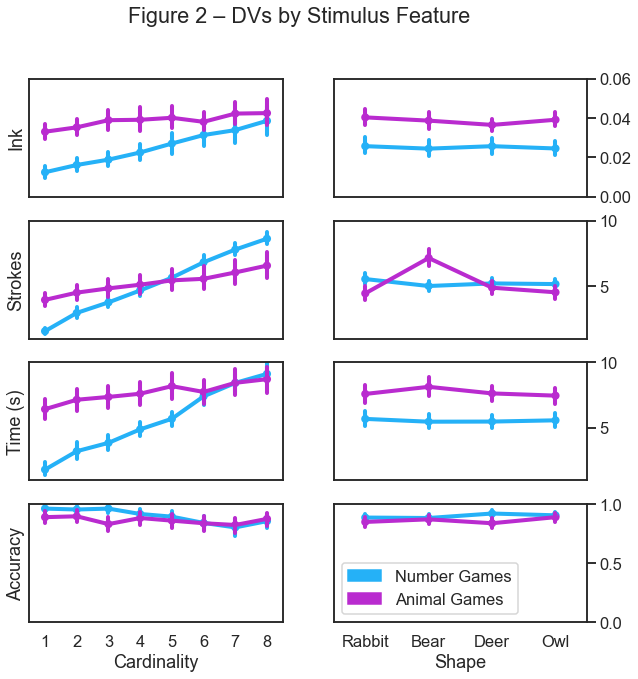

In [11]:
# Figure 2 produced as follows, showing each naive measure over cardinality & animal

# set what data we want to plot; this can be any trial block, or all blocks
num_data = df_num
aml_data = df_aml

# overall figure parameters
graph_size = (5,2)
card_fig = plt.figure("By Cardinality",figsize=(10,10))
card_fig.suptitle("Figure 2 – DVs by Stimulus Feature")
# card_fig.suptitle("        ")

ax1 = card_fig.add_subplot(4,2,1)
ax2 = card_fig.add_subplot(4,2,2)
ax3 = card_fig.add_subplot(4,2,3)
ax4 = card_fig.add_subplot(4,2,4)
ax5 = card_fig.add_subplot(4,2,5)
ax6 = card_fig.add_subplot(4,2,6)
ax7 = card_fig.add_subplot(4,2,7)
ax8 = card_fig.add_subplot(4,2,8)

## the legend, if ever we want to put it in
number_patch = mpatches.Patch(color='#25B1F7', label='Number Games')
animal_patch = mpatches.Patch(color='#B92BCF', label='Animal Games')
plt.legend(handles=[number_patch, animal_patch])



# for all the odd subplots, plot out DVs over cardinality

# plt.figure("Ink over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='meanPixelIntensity',color='#25B1F7',markers='.',ax=ax1)
sns.pointplot(data=aml_data, x='cardinality', y='meanPixelIntensity',color='#B92BCF',markers='.',ax=ax1)
# plt.title("Ink by Cardinality")
# plt.ylabel("Ink")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Strokes over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='numStrokes',color='#25B1F7',markers='.',ax=ax3)
sns.pointplot(data=aml_data, x='cardinality', y='numStrokes',color='#B92BCF',markers='.',ax=ax3)
# plt.title("Strokes by Cardinality")
# plt.ylabel("Strokes")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Sketch Time over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='drawDuration',color='#25B1F7',markers='.',ax=ax5)
sns.pointplot(data=aml_data, x='cardinality', y='drawDuration',color='#B92BCF',markers='.',ax=ax5)
# plt.title("Sketch Time by Cardinality")
# plt.ylabel("Sketch Time")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Accuracy over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='outcome',color='#25B1F7',markers='.',ax=ax7)
sns.pointplot(data=aml_data, x='cardinality', y='outcome',color='#B92BCF',markers='.',ax=ax7)
# plt.title("Accuracy by Cardinality")
# plt.ylabel("Accuracy")
# plt.xlabel("Cardinality")





# for all the even subplots, plot out DVs over animal

# plt.figure("Ink over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='meanPixelIntensity',color='#25B1F7',markers='.',ax=ax2)
sns.pointplot(data=aml_data, x='category', y='meanPixelIntensity',color='#B92BCF',markers='.',ax=ax2)
# plt.title("Ink by Animal Type")
# plt.ylabel("Ink")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Strokes over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='numStrokes',color='#25B1F7',markers='.',ax=ax4)
sns.pointplot(data=aml_data, x='category', y='numStrokes',color='#B92BCF',markers='.',ax=ax4)
# plt.title("Strokes by Animal Type")
# plt.ylabel("Strokes")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Sketch Time over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='drawDuration',color='#25B1F7',markers='.',ax=ax6)
sns.pointplot(data=aml_data, x='category', y='drawDuration',color='#B92BCF',markers='.',ax=ax6)
# plt.title("Sketch Time by Animal Type")
# plt.ylabel("Sketch Time")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Accuracy over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='outcome',color='#25B1F7',markers='.',ax=ax8)
sns.pointplot(data=aml_data, x='category', y='outcome',color='#B92BCF',markers='.',ax=ax8)
# plt.title("Accuracy by Animal Type")
# plt.ylabel("Accuracy")
# plt.xlabel("Animal Type")

# Set the labels, ticks, and limits (note: limits are set to accommodate data averaged across blocks
# individual block data goes beyond the y limits set below)
ax1.set_ylabel("Ink")
ax3.set_ylabel("Strokes")
ax5.set_ylabel("Time (s)")
ax7.set_ylabel("Accuracy")
ax2.set_ylabel("")
ax4.set_ylabel("")
ax6.set_ylabel("")
ax8.set_ylabel("")
ax1.set_yticks([])
ax3.set_yticks([])
ax5.set_yticks([])
ax7.set_yticks([])


ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("")
ax7.set_xlabel("Cardinality")
ax8.set_xlabel("Shape")


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax6.set_xticks([])
ax7.set_xticklabels([1,2,3,4,5,6,7,8])
ax8.set_xticklabels(['Rabbit','Bear','Deer','Owl'])

ax1.set_ylim([0, .06])
ax2.set_ylim([0, .06])
ax3.set_ylim([1, 10])
ax4.set_ylim([1, 10])
ax5.set_ylim([1, 10])
ax6.set_ylim([1, 10])
ax7.set_ylim([0, 1])
ax8.set_ylim([0, 1])

ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax6.yaxis.tick_right()
ax8.yaxis.tick_right()

plt.show()

card_fig.savefig('../results/plots/DVs.pdf')


### Figure 4: Correlations over Blocks

<function matplotlib.pyplot.show(close=None, block=None)>

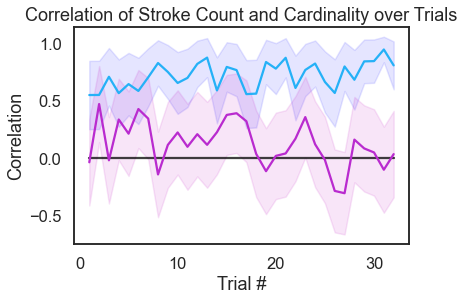

In [17]:
# Plot correlations by trial number (this does not make it into figure 4, but is interesting)
DV = 'numStrokes' # 'outcome', 'drawDuration', 'numStrokes', 'meanPixelIntensity'
num_corr_trials = []
aml_corr_trials = []

def corr_confint(corrcoef,N,tc=1.96):
    sr = np.sqrt((1-corrcoef**2)/(N-2))
    return sr*tc

for trialnum in np.arange(1,33):
    num_trial = df_num.loc[df_num['trialNum'] == trialnum]
    aml_trial = df_aml.loc[df_aml['trialNum'] == trialnum]
    num_corr_trial = stats.pearsonr(num_trial['cardinality'], num_trial[DV])[0]
    aml_corr_trial = stats.pearsonr(aml_trial['cardinality'], aml_trial[DV])[0]
    num_corr_trials.append(num_corr_trial)
    aml_corr_trials.append(aml_corr_trial)
    #num_confints.append()
    
    
num_corr_trials = np.array(num_corr_trials)
aml_corr_trials = np.array(aml_corr_trials)
    
num_confints = corr_confint(num_corr_trials, len(np.unique(df_num['gameID'])))
aml_confints = corr_confint(aml_corr_trials, len(np.unique(df_aml['gameID'])))

plt.figure("Correlations (line chart)")
plt.title("Correlation of Stroke Count and Cardinality over Trials")
plt.plot(np.arange(1,33),32*[0],color='black',alpha = .75)
plt.plot(np.arange(1,33),num_corr_trials,color='#25B1F7')
plt.plot(np.arange(1,33),aml_corr_trials,color='#B92BCF')
plt.fill_between(np.arange(1,33), (num_corr_trials-num_confints), (num_corr_trials+num_confints), color='b', alpha=.1)   
plt.fill_between(np.arange(1,33), (aml_corr_trials-aml_confints), (aml_corr_trials+aml_confints), color='m', alpha=.1)    
plt.ylabel("Correlation")
plt.xlabel("Trial #")
plt.show




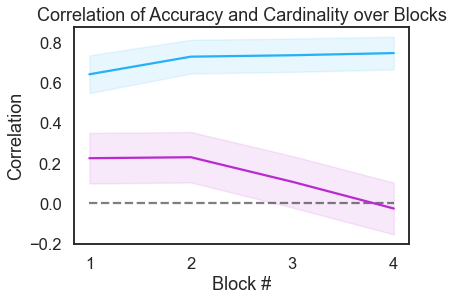

In [18]:
# Plot correlations by block number
DV = 'numStrokes' # 'outcome', 'drawDuration', 'numStrokes', 'meanPixelIntensity'
num_corr_blocks = []
aml_corr_blocks = []

for blocknum in np.arange(1,5):
    num_block = df_num.loc[df_num['quarter'] == blocknum]
    aml_block = df_aml.loc[df_aml['quarter'] == blocknum]
    num_corr_block = stats.pearsonr(num_block['cardinality'], num_block[DV])[0]
    aml_corr_block = stats.pearsonr(aml_block['cardinality'], aml_block[DV])[0]
    num_corr_blocks.append(num_corr_block)
    aml_corr_blocks.append(aml_corr_block)
    
    
num_corr_blocks = np.array(num_corr_blocks)
aml_corr_blocks = np.array(aml_corr_blocks)

#make sure this is the right way to do N samples - it's total trials, so 8 per block times number of games
num_confints = corr_confint(num_corr_blocks, 8*len(np.unique(df_num['gameID'])))
aml_confints = corr_confint(aml_corr_blocks, 8*len(np.unique(df_aml['gameID'])))

plt.figure("Correlations (line chart)")
plt.title("Correlation of Accuracy and Cardinality over Blocks")
plt.plot(np.arange(1,5),4*[0],color='black',alpha = .5,linestyle='--')
plt.plot(np.arange(1,5),num_corr_blocks,color='#25B1F7')
plt.plot(np.arange(1,5),aml_corr_blocks,color='#B92BCF')
plt.fill_between(np.arange(1,5), (num_corr_blocks-num_confints), (num_corr_blocks+num_confints), color='#25B1F7', alpha=.1)   
plt.fill_between(np.arange(1,5), (aml_corr_blocks-aml_confints), (aml_corr_blocks+aml_confints), color='#B92BCF', alpha=.1)    
plt.ylabel("Correlation")
plt.xlabel("Block #")
plt.show()




In [22]:

ratio_DF = get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['ratio'].agg(['mean', 'count', 'std'])))

# ratio_correct_DF = get_confint(pd.DataFrame(D[D['outcome']==1].groupby(['Game_Condition'])['ratio'].agg(['mean', 'count', 'std'])))


get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['outcome'].agg(['mean', 'count', 'std'])))



D['one2one'] = D['ratio'] == 1
D['compressed'] = D['ratio'] < 1
D['compressed'].mean()
D['allgames'] = 1

get_confint(pd.DataFrame(D.groupby(['Game_Condition']).agg(['mean', 'count', 'std']))['one2one'])



,mean,count,std,ci95_hi,ci95_lo
Game_Condition,,,,,
number,0.068359,1024,0.252485,0.083824,0.052895
shape,0.076509,928,0.265954,0.093620,0.059397


Text(0, 0.5, 'Count')

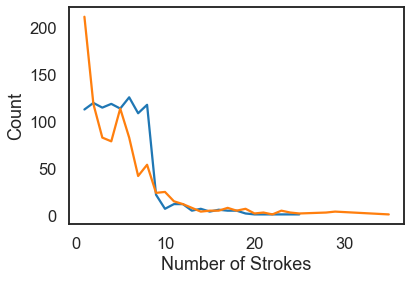

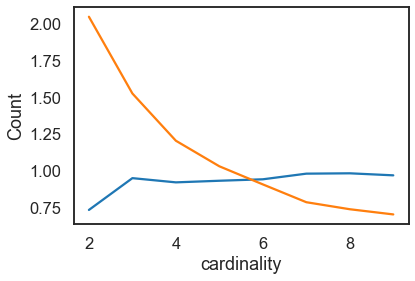

In [23]:

plt.figure()
D[D['Game_Condition']=='number'].groupby(['numStrokes'])['numStrokes'].count().plot()
D[D['Game_Condition']=='shape'].groupby(['numStrokes'])['numStrokes'].count().plot()
plt.xlabel("Number of Strokes")
plt.ylabel("Count")

plt.figure()
D[D['Game_Condition']=='number'].groupby(['cardinality'])['ratio'].mean().plot()
D[D['Game_Condition']=='shape'].groupby(['cardinality'])['ratio'].mean().plot()
# plt.xlabel("Stroke Ratio")
plt.ylabel("Count")


# Figures for CogSci

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


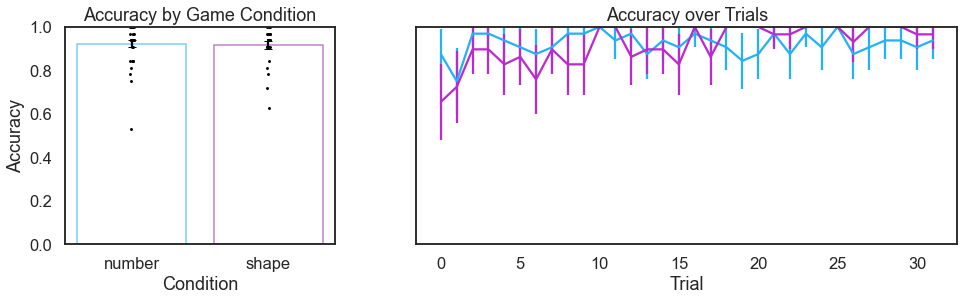

In [24]:
# colours: number #25B1F7; shape #B92BCF
# Fig 1 straightforward accuracy measures for each condition
num_data = df_num
aml_data = df_aml

acc_DF = get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['outcome'].agg(['mean', 'count', 'std'])))
subject_acc = pd.DataFrame(D.groupby(['Game_Condition','gameID'])['outcome'].mean()).reset_index()

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(16,4),gridspec_kw={'width_ratios': [1, 2]})
# fig.suptitle("Accuracy by Game Condition")
# ax1 = fig.add_subplot(1,2,1)

ax1.set_title("Accuracy by Game Condition")
ax1.bar(acc_DF.reset_index()['Game_Condition'],
        height=acc_DF['mean'],
        width=.8,
        yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
        capsize=4)
ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Condition")


num_acc_trial_DF = get_confint(pd.DataFrame(df_num.groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
aml_acc_trial_DF = get_confint(pd.DataFrame(df_aml.groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))

# ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(range(len(num_acc_trial_DF)),num_acc_trial_DF['mean'],c='#25B1F7',
             yerr=num_acc_trial_DF['ci95_hi']-num_acc_trial_DF['mean'])

ax2.errorbar(range(len(aml_acc_trial_DF)),aml_acc_trial_DF['mean'],c='#B92BCF',
             yerr=aml_acc_trial_DF['ci95_hi']-aml_acc_trial_DF['mean'])

ax2.set_title("Accuracy over Trials")

ax2.set_ylim([0,1])
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.set_xlabel("Trial")

ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[1].set_edgecolor('#7DCCF4')
ax1.get_children()[2].set_edgecolor('#BD83C7')


num_subject_acc = np.array(subject_acc[subject_acc['Game_Condition']=='number']['outcome'])
aml_subject_acc = np.array(subject_acc[subject_acc['Game_Condition']=='shape']['outcome'])
ax1.scatter(0 + np.random.random(num_subject_acc.size) * .03 - .01, num_subject_acc, color='k',s=2)
ax1.scatter(1 + np.random.random(aml_subject_acc.size) * .03 - .01, aml_subject_acc, color='k',s=2)

fig.show()


## just accuracy to put on the same scale as recog acc and model acc

In [25]:
acc_DF.to_csv("../results/csv/itnerum1_accuracy.csv")

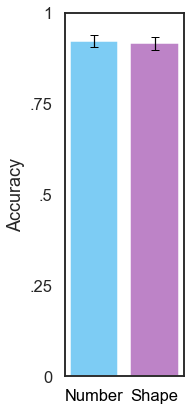

In [26]:

fig , (ax1) = plt.subplots(1,1 , figsize = (3,6)) # 

ax1.set_ylim(0,1)

# fig.suptitle("Guessers", fontsize=24)                # version 1

ax1.bar(acc_DF.reset_index()['Game_Condition'],
        height=acc_DF['mean'],
        color = ['#7DCCF4','#BD83C7'], alpha=1,
        yerr= acc_DF['ci95_hi']-acc_DF['mean'],
        error_kw={'linewidth':1.2,'capsize':4})


# ax1.set_xlabel("Animals",color='#A04EAE')
# ax1.set_xticklabels([])
ax1.set_yticks([0,.25,.5,.75,1])
ax1.set_yticklabels(['0','.25','.5','.75','1'])
ax1.set_xticks([0,1])
ax1.set_xticklabels(["Number","Shape"],color='k')

# l1=ax1.axhline(0.25,color='black',ls='--')
# l1.set_label('l1')

# l2=ax2.axhline(0.125,color='black',ls='--')
# l2.set_label('l2')

# ax2.set_yticks([0,.25,.5,.75,1])
# ax2.set_yticklabels(['0','.25','.5','.75','1'])
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
ax1.set_ylabel("Accuracy")#,position=(1.5,.5))
# ax2.tick_params(axis='y',  labelright='on')


fig.subplots_adjust(left=.2, right=.8,top=.9,bottom=0.2)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)


fig.savefig('../results/plots/accGuesser.pdf')

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


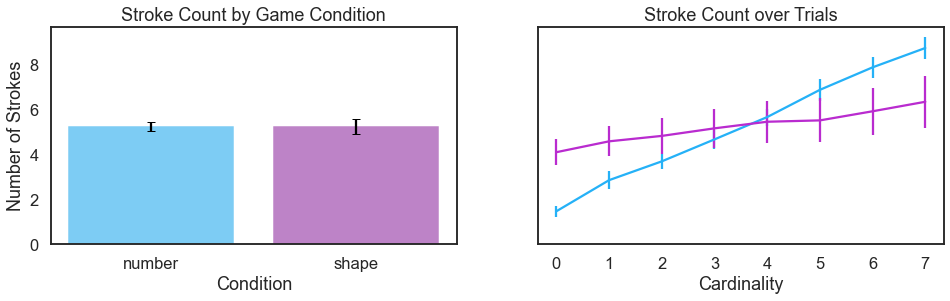

In [27]:
# do only stroke count here
str_DF = get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['numStrokes'].agg(['mean', 'count', 'std'])))

num_str_trial_DF = get_confint(pd.DataFrame(df_num.groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))
aml_str_trial_DF = get_confint(pd.DataFrame(df_aml.groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))

numgames_str_trial_DF = get_confint(pd.DataFrame(df_num.groupby(['gameID','trialNum'])['numStrokes'].agg(['mean', 'count', 'std'])))
amlgames_str_trial_DF = get_confint(pd.DataFrame(df_aml.groupby(['gameID','trialNum'])['numStrokes'].agg(['mean', 'count', 'std'])))


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,4),sharey=True)
# fig.suptitle("Stroke Count by Condition (Total & Over Time)")
# ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Stroke Count by Game Condition")
ax1.bar(str_DF.reset_index()['Game_Condition'],
       height=str_DF['mean'],
       yerr=[str_DF['ci95_hi']-str_DF['mean'], str_DF['mean']-str_DF['ci95_lo']],
       capsize=4)

ax1.set_ylabel("Number of Strokes")
ax1.set_xlabel("Condition")


# ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(range(len(num_str_trial_DF)),num_str_trial_DF['mean'],c='#25B1F7',
             yerr=num_str_trial_DF['ci95_hi']-num_str_trial_DF['mean'])

ax2.errorbar(range(len(aml_str_trial_DF)),aml_str_trial_DF['mean'],c='#B92BCF',
             yerr=aml_str_trial_DF['ci95_hi']-aml_str_trial_DF['mean'])

ax2.set_title("Stroke Count over Trials")
# ax2.set_ylabel("")
# ax2.set_yticks([])
# ax2.yaxis.tick_right()
ax2.set_xlabel("Cardinality")

ax1.get_children()[1].set_color('#7DCCF4')
ax1.get_children()[2].set_color('#BD83C7')

fig.show()


Text(0.5, 0, 'Cardinality')

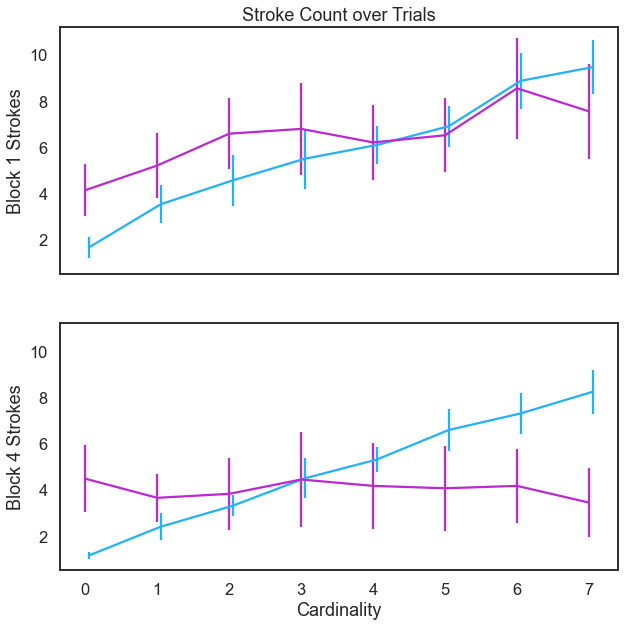

In [28]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,10),sharex=True,sharey=True)


tempNum1 = get_confint(pd.DataFrame(df_num[df_num['quarter']==1].groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))
tempNum2 = get_confint(pd.DataFrame(df_num[df_num['quarter']==4].groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))

tempAml1 = get_confint(pd.DataFrame(df_aml[df_aml['quarter']==1].groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))
tempAml2 = get_confint(pd.DataFrame(df_aml[df_aml['quarter']==4].groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))


ax1.errorbar(range(len(tempNum1))+np.array(len(tempNum1)*[.05]),tempNum1['mean'],c='#25B1F7',
             yerr=tempNum1['ci95_hi']-tempNum1['mean'])
ax1.errorbar(range(len(tempAml1)),tempAml1['mean'],c='#B92BCF',
             yerr=tempAml1['ci95_hi']-tempAml1['mean'])

ax2.errorbar(range(len(tempNum2))+np.array(len(tempNum2)*[.05]),tempNum2['mean'],c='#25B1F7',
             yerr=tempNum2['ci95_hi']-tempNum2['mean'])
ax2.errorbar(range(len(tempAml2)),tempAml2['mean'],c='#B92BCF',
             yerr=tempAml2['ci95_hi']-tempAml2['mean'])


ax1.set_title("Stroke Count over Trials")
ax1.set_ylabel("Block 1 Strokes")
ax2.set_ylabel("Block 4 Strokes")
ax2.set_xlabel("Cardinality")


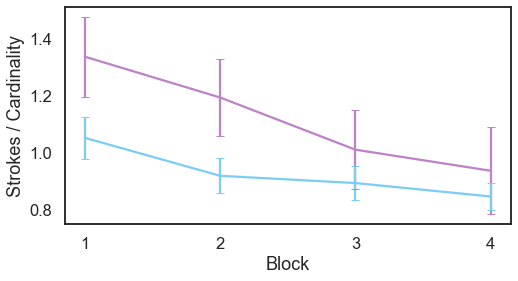

In [29]:

temp1 = get_confint(D[D['Game_Condition'] == 'shape'].groupby(['quarter'])[['ratio']].agg(['mean','count','std']))
temp2 = get_confint(D[D['Game_Condition'] == 'number'].groupby(['quarter'])[['ratio']].agg(['mean','count','std']))


f , ax = plt.subplots(1,1,figsize=(8,4))
# D[D['Game_Condition'] == 'shape'].groupby(['trialNum'])[['ratio']].mean().plot(ax=ax,c='#BD83C7',legend=False,yerr=.05)  
# D[D['Game_Condition'] == 'number'].groupby(['trialNum'])[['ratio']].mean().plot(ax=ax,c='#7DCCF4',legend=False)


temp1['ratio']['mean'].plot(ax=ax,c='#BD83C7',yerr=temp1['ci95_hi']-temp1['ratio']['mean'],capsize=4,legend=False)  
temp2['ratio']['mean'].plot(ax=ax,c='#7DCCF4',yerr=temp2['ci95_hi']-temp2['ratio']['mean'],capsize=4,legend=False)  

ax.set_ylabel("Strokes / Cardinality")
ax.set_xlabel("Block")
ax.set_xticks([1,2,3,4])




# temp1

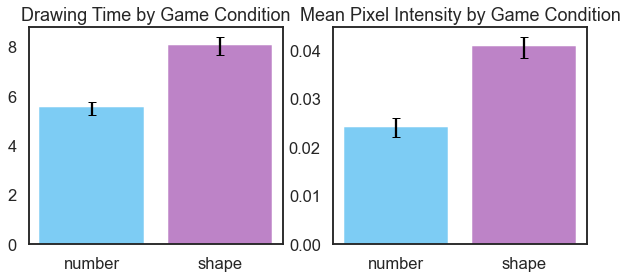

In [30]:
# RT isn't really RT, it's actually drawing time. STR is stroke count
RTs = get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['drawDuration'].agg(['mean', 'count', 'std'])))
INK = get_confint(pd.DataFrame(D.groupby(['Game_Condition'])['meanPixelIntensity'].agg(['mean', 'count', 'std'])))

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ax1.set_title("Drawing Time by Game Condition")
ax1.bar(RTs.reset_index()['Game_Condition'],
       height=RTs['mean'],
       yerr=[RTs['ci95_hi']-RTs['mean'], RTs['mean']-RTs['ci95_lo']],
       capsize=4)
ax1.get_children()[1].set_color('#7DCCF4')
ax1.get_children()[2].set_color('#BD83C7')

ax2.set_title("Mean Pixel Intensity by Game Condition")
ax2.bar(INK.reset_index()['Game_Condition'],
       height=INK['mean'],
       yerr=[INK['ci95_hi']-INK['mean'], INK['mean']-INK['ci95_lo']],
       capsize=4)
ax2.get_children()[1].set_color('#7DCCF4')
ax2.get_children()[2].set_color('#BD83C7')



## Figure for Manuscript

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


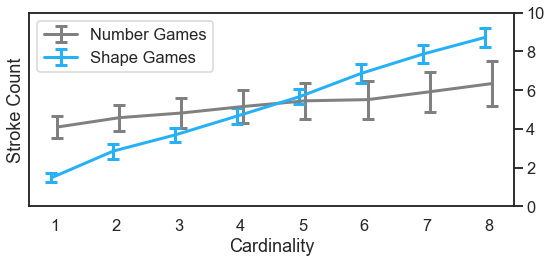

In [59]:
# Figure for CogSci

lw = 3
cs = 6

fig , ax2 = plt.subplots(1,1,figsize=(8,4))#,gridspec_kw={'width_ratios': [1, 3]})
# fig.suptitle("Accuracy by Game Condition")
# ax1 = fig.add_subplot(1,2,1)

# ax1.set_title("Accuracy by Game Condition")

# ax1.bar(acc_DF.reset_index()['Game_Condition'],
#         height=acc_DF['mean'],
#         width=.8,
#         yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
#         capsize=cs)
# ax1.set_ylim([0,1])
# ax1.set_ylabel("Accuracy")
# ax1.set_xlabel("Condition")

# num_acc_trial_DF = get_confint(pd.DataFrame(df_num.groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
# aml_acc_trial_DF = get_confint(pd.DataFrame(df_aml.groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))



ax2.errorbar(np.arange(1,len(aml_str_trial_DF)+1)+.05,aml_str_trial_DF['mean'],c='grey',linewidth=lw,
             yerr=aml_str_trial_DF['ci95_hi']-aml_str_trial_DF['mean'],
             capsize=cs, elinewidth=lw, markeredgewidth=lw)

ax2.errorbar(np.arange(1,len(num_str_trial_DF)+1)-.05,num_str_trial_DF['mean'],c='#25B1F7',linewidth=lw,
             yerr=num_str_trial_DF['ci95_hi']-num_str_trial_DF['mean'],
             capsize=cs, elinewidth=lw, markeredgewidth=lw)


ax2.legend(('Number Games', 'Shape Games'),loc="upper left")
# to plot accuracy over cardinality
# acc_by_card_num = get_confint(pd.DataFrame(df_num.groupby(['gameID','cardinality'])['outcome'].agg(['mean', 'count', 'std'])))
# acc_by_card_aml

# ax2.set_title("Stroke Count over Trials")
ax2.yaxis.tick_right()
ax2.set_xlabel("Cardinality")
ax2.set_ylabel("Stroke Count")
ax2.set_ylim(0,np.ceil(np.max(num_str_trial_DF['ci95_hi']))) # set y-limit to be the nearest integer above max err val

# ax1.get_children()[1].set_color((0,0,0,0))
# ax1.get_children()[2].set_color((0,0,0,0))
# ax1.get_children()[1].set_edgecolor('#7DCCF4')
# ax1.get_children()[2].set_edgecolor('grey')


# show points as either subject accuracies, or cardinality / animals. If we want by subjects:
num_subject_acc = np.array(subject_acc[subject_acc['Game_Condition']=='number']['outcome'])
aml_subject_acc = np.array(subject_acc[subject_acc['Game_Condition']=='shape']['outcome'])
# and if we want by cardinality / animal:
cardinality_acc = np.array(pd.DataFrame(D[D['Game_Condition']=='number'].groupby(['cardinality'])['outcome'].mean()).reset_index()['outcome'])
animal_acc =      np.array(pd.DataFrame(D[D['Game_Condition']=='shape' ].groupby(['category'])['outcome'].mean()).reset_index()['outcome'])

# ax1.scatter(0 + np.random.random(num_subject_acc.size) * .03, num_subject_acc, color='#7DCCF4',s=16,alpha=.6)
# ax1.scatter(1 + np.random.random(aml_subject_acc.size) * .03, aml_subject_acc, color='grey',s=16,alpha=.6)

plt.tight_layout()
fig.savefig('../results/plots/acc_stroke.pdf')

# https://stackoverflow.com/questions/51027717/pyplot-bar-charts-with-individual-data-points/51032760
fig.show()


In [38]:
np.arange(1,len(aml_str_trial_DF)+1)+.05

array([1.05, 2.05, 3.05, 4.05, 5.05, 6.05, 7.05, 8.05])

### Plot any old thing over any other old thing

<ErrorbarContainer object of 3 artists>

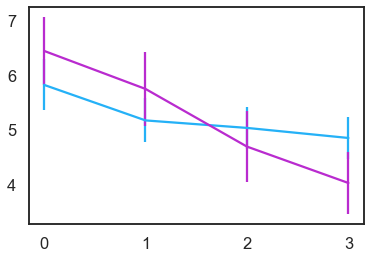

In [32]:
# groupby: trialNum, quarter, Game_Condition
# outcome, numStrokes, meanPixelIntensity, drawDuration

num_overtime = get_confint(pd.DataFrame(df_num.groupby(['quarter'])['numStrokes'].agg(['mean', 'count', 'std'])))
aml_overtime = get_confint(pd.DataFrame(df_aml.groupby(['quarter'])['numStrokes'].agg(['mean', 'count', 'std'])))

plt.figure()
plt.errorbar(range(len(num_overtime)),num_overtime['mean'],c='#25B1F7',
             yerr=num_overtime['ci95_hi']-num_overtime['mean'])

plt.errorbar(range(len(aml_overtime)),aml_overtime['mean'],c='#B92BCF',
             yerr=aml_overtime['ci95_hi']-aml_overtime['mean'])
